<a href="https://colab.research.google.com/github/AbrahamKong/CMPE258_Practice_transfer_learning_and_supervised_contrastive_learning/blob/main/supervised_contrastive_learning_Using_new_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Contrastive Learning Loss based Supervised Classification

## Set Up

In [1]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

## Prepare the data

In [3]:
num_classes = 10
input_shape = (32, 32, 3)

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

Exception: ignored

## Using image data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomWidth(0.2),
        layers.RandomHeight(0.2),
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

## Build the encoder model

The encoder model takes the image as input and turns it into a 2048-dimensional
feature vector.

In [ ]:

def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-encoder")
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 265
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05

## Build the classification model

The classification model adds a fully-connected layer on top of the encoder,
plus a softmax layer with the target classes.

In [ ]:

def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model


## Experiment 1: Train the baseline classification model

In this experiment, a baseline classifier is trained as usual, i.e., the
encoder and the classifier parts are trained together as a single model
to minimize the crossentropy loss.

In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")


## Experiment 2: Use supervised contrastive learning

In this experiment, the model is trained in two phases. In the first phase,
the encoder is pretrained to optimize the supervised contrastive loss,
described in [Prannay Khosla et al.](https://arxiv.org/abs/2004.11362).

In the second phase, the classifier is trained using the trained encoder with
its weights freezed; only the weights of fully-connected layers with the
softmax are optimized.

### 1. Supervised contrastive learning loss function

In [ ]:

class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="cifar-encoder_with_projection-head"
    )
    return model


### 2. Pretrain the encoder

In [ ]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(
    x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs
)

### 3. Train the classifier with the frozen encoder

In [ ]:
classifier = create_classifier(encoder, trainable=False)

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

## Conclusion

As shown in the experiments, using the supervised contrastive learning technique
outperformed the conventional technique in terms of the test accuracy. Note that
the same training budget (i.e., number of epochs) was given to each technique.
Supervised contrastive learning pays off when the encoder involves a complex
architecture, like ResNet, and multi-class problems with many labels.
In addition, large batch sizes and multi-layer projection heads
improve its effectiveness. See the [Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
paper for more details.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/supervised-contrastive-learning-cifar10) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/supervised-contrastive-learning).

# Softmax based Supervised Classification

## Set Up

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0


## Import the Fashion MNIST dataset

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explore the data

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
len(train_labels)

60000

In [7]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [8]:
test_images.shape

(10000, 28, 28)

In [9]:
len(test_labels)

10000

## Preprocess the data

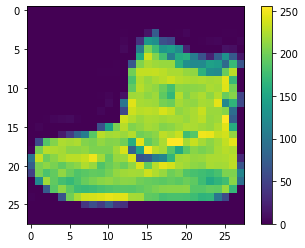

In [10]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [11]:
train_images = train_images / 255.0

test_images = test_images / 255.0

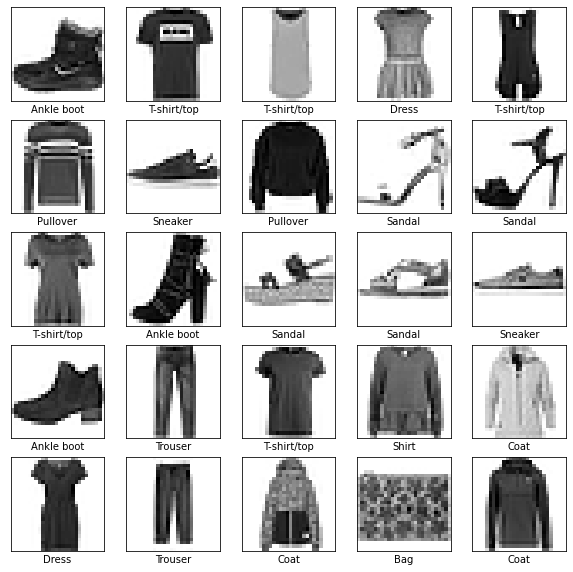

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build the Model

### Set up the layers

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

### Compile the model

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

### Feed the model

In [15]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4975 - accuracy: 0.8245
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3766 - accuracy: 0.8639
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3371 - accuracy: 0.8782
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3147 - accuracy: 0.8847
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2961 - accuracy: 0.8905
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2805 - accuracy: 0.8969
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2671 - accuracy: 0.9004
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2561 - accuracy: 0.9039
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2485 - accuracy: 0.9083
Epoch 10/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.237

### Evaluate accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3362 - accuracy: 0.8830 - 552ms/epoch - 2ms/step

Test accuracy: 0.8830000162124634


### Make predictions

In [17]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [18]:
predictions = probability_model.predict(test_images)

In [19]:
predictions[0]

array([1.1977914e-08, 1.5615851e-09, 2.8564726e-08, 4.1281027e-09,
       9.1540375e-09, 1.3864968e-03, 2.1767664e-07, 1.1144890e-02,
       5.2356981e-09, 9.8746836e-01], dtype=float32)

In [20]:
np.argmax(predictions[0])

9

In [21]:
test_labels[0]

9

In [22]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

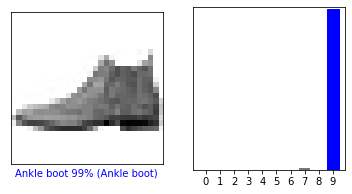

In [23]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

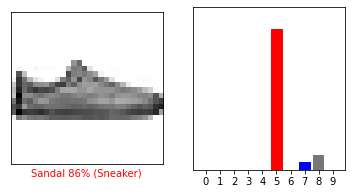

In [24]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

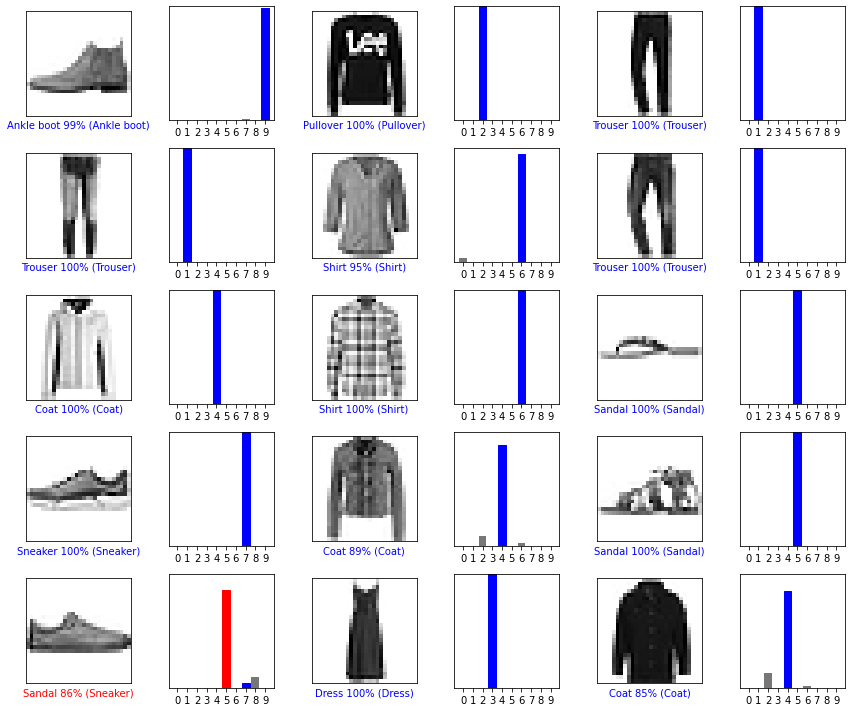

In [25]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Use the trained model

In [26]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


In [27]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [28]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[4.4069075e-05 5.2997867e-12 9.9951708e-01 6.9477613e-10 3.8799417e-04
  1.9272914e-12 5.0920895e-05 1.7400742e-19 5.0135612e-10 3.2390410e-11]]


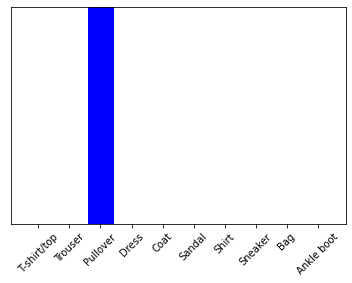

In [29]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

In [30]:
np.argmax(predictions_single[0])

2

# Reference

1. [supervised-contrastive-learning](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/supervised-contrastive-learning.ipynb#scrollTo=SzsWDuDklBll)
2. [Basic classification: Classify images of clothing](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb?hl=id-IDCache)